First few rows of the data:


,director_name,num_critic_for_reviews,director_facebook_likes,actor_3_facebook_likes,actor_2_name,actor_1_facebook_likes,genres,actor_1_name,movie_title,num_voted_users,cast_total_facebook_likes,actor_3_name,facenumber_in_poster,movie_imdb_link,num_user_for_reviews,title_year,actor_2_facebook_likes,imdb_score,movie_facebook_likes
0,James Cameron,723.0,0.0,855.0,Joel David Moore,1000.0,Action|Adventure|Fantasy|Sci-Fi,CCH Pounder,avatar,886204,4834,Wes Studi,0.0,http://www.imdb.com/title/tt0499549/?ref_=fn_t...,3054.0,2009.0,936.0,7.9,33000
1,Gore Verbinski,302.0,563.0,1000.0,Orlando Bloom,40000.0,Action|Adventure|Fantasy,Johnny Depp,pirates of the caribbean: at world's end,471220,48350,Jack Davenport,0.0,http://www.imdb.com/title/tt0449088/?ref_=fn_t...,1238.0,2007.0,5000.0,7.1,0
2,Sam Mendes,602.0,0.0,161.0,Rory Kinnear,11000.0,Action|Adventure|Thriller,Christoph Waltz,spectre,275868,11700,Stephanie Sigman,1.0,http://www.imdb.com/title/tt2379713/?ref_=fn_t...,994.0,2015.0,393.0,6.8,85000
3,Christopher Nolan,813.0,22000.0,23000.0,Christian Bale,27000.0,Action|Thriller,Tom Hardy,the dark knight rises,1144337,106759,Joseph Gordon-Levitt,0.0,http://www.imdb.com/title/tt1345836/?ref_=fn_t...,2701.0,2012.0,23000.0,8.5,164000
4,Doug Walker,NaN,131.0,NaN,Rob Walker,131.0,Documentary,Doug Walker,star wars: episode vii - the force awakens,8,143,None,0.0,http://www.imdb.com/title/tt5289954/?ref_=fn_t...,NaN,NaN,12.0,7.1,0


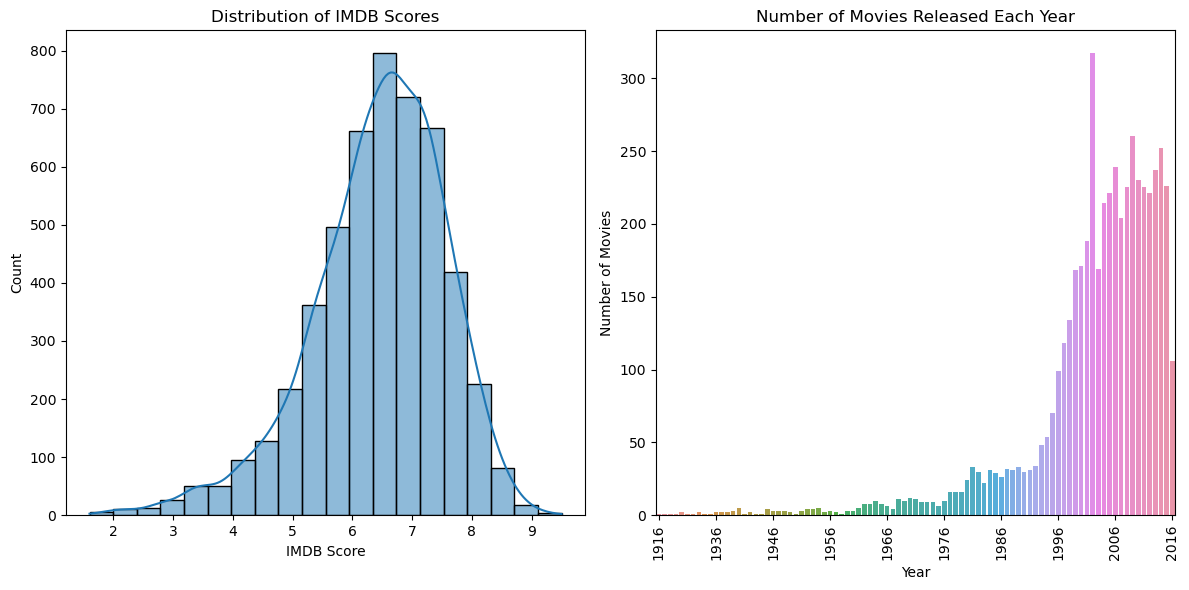

In [1]:
import pandas as pd
import sqlite3
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

def load_data_from_csv(filepath):
    data = pd.read_csv(filepath)
    # Normalize movie titles in the dataset
    data['movie_title'] = data['movie_title'].str.lower().str.strip()
    return data

def save_data_to_sql(data, db_name='movie_database.sqlite', table_name='movies'):
    conn = sqlite3.connect(db_name)
    data.to_sql(table_name, conn, if_exists='replace', index=False)
    conn.close()

def load_data_from_sql(db_name='movie_database.sqlite', table_name='movies'):
    conn = sqlite3.connect(db_name)
    query = f"SELECT * FROM {table_name}"
    data = pd.read_sql_query(query, conn)
    conn.close()
    return data

def clean_and_prepare_data(data):
    data.dropna(inplace=True)
    data['title_year'] = data['title_year'].fillna(data['title_year'].mean()).astype(int)
    data = pd.get_dummies(data, columns=['director_name', 'actor_1_name'])
    features = data.select_dtypes(include=[np.number])
    features = features.drop('imdb_score', axis=1) # remove the target column from the features
    labels = data['imdb_score'] > data['imdb_score'].mean()
    return train_test_split(features, labels, test_size=0.2, random_state=42)

def train_and_evaluate_model(X_train, y_train, X_test, y_test, model):
    model.fit(X_train, y_train)
    predictions = model.predict(X_test)
    return accuracy_score(y_test, predictions)

data = load_data_from_csv('/Users/xueyilu/Desktop/Project-4/cleaned_data.csv')
# data = load_data_from_csv('cleaned_data.csv')

save_data_to_sql(data)
data = load_data_from_sql()

# Display the first few rows of the DataFrame
print("First few rows of the data:")
display(data.head())

# Plotting
def plot_data(data):
    plt.figure(figsize=(12, 6))

    # Histogram of IMDB Scores
    plt.subplot(1, 2, 1)
    sns.histplot(data['imdb_score'], bins=20, kde=True)
    plt.title('Distribution of IMDB Scores')
    plt.xlabel('IMDB Score')
    plt.ylabel('Count')

    # Convert 'title_year' to integer
    # Handle NaN values and convert 'title_year' to integer
    data['title_year'] = data['title_year'].fillna(data['title_year'].mean()).astype(int)


    # Bar Chart of Movies by Year
    plt.subplot(1, 2, 2)
    year_counts = data['title_year'].value_counts().sort_index()
    sns.barplot(x=year_counts.index, y=year_counts.values)
    plt.title('Number of Movies Released Each Year')
    plt.xlabel('Year')
    plt.ylabel('Number of Movies')

    # Rotate x-axis labels for better visibility and reduce the number of x-ticks
    xticks = plt.xticks()[0]
    plt.xticks(xticks[::10], rotation=90)  # Display every 10th label

    plt.tight_layout()
    plt.show()

# Call the plotting function
plot_data(data)

X_train, X_test, y_train, y_test = clean_and_prepare_data(data)
# rf_model = RandomForestClassifier(n_estimators=500, max_depth=5, random_state=42)
# rf_accuracy = train_and_evaluate_model(X_train, y_train, X_test, y_test, rf_model)


In [6]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer, accuracy_score
from sklearn.metrics import classification_report

# Define the parameter grid for Random Forest
param_grid = {
    'n_estimators': [100, 200, 500],
    'max_depth': [None, 5, 10, 15],
    'random_state': [42]
}

# Initialize a RandomForestClassifier
rf_model = RandomForestClassifier()

# Define a custom scoring function (lower is better)
def custom_accuracy(y_true, y_pred):
    return 1 - accuracy_score(y_true, y_pred)

# Initialize a GridSearchCV object with custom scoring
grid_search = GridSearchCV(estimator=rf_model, param_grid=param_grid,
                           cv=10, n_jobs=-1, scoring=make_scorer(custom_accuracy))

# Fit the GridSearchCV object to the data
grid_search.fit(X_train, y_train)

# Get the best parameters
best_params = grid_search.best_params_

# Train a new RandomForestClassifier with the best parameters
rf_model_best = RandomForestClassifier(**best_params)
rf_model_best.fit(X_train, y_train)

# Make predictions on the training and testing data
y_train_pred = rf_model_best.predict(X_train)
y_test_pred = rf_model_best.predict(X_test)

# Calculate classification report for training data
print("Classification Report for Training Data:")
print(classification_report(y_train, y_train_pred))

# Calculate classification report for testing data
print("\nClassification Report for Testing Data:")
print(classification_report(y_test, y_test_pred))


Classification Report for Training Data:
              precision    recall  f1-score   support

       False       0.70      0.75      0.72      1780
        True       0.78      0.73      0.75      2112

    accuracy                           0.74      3892
   macro avg       0.74      0.74      0.74      3892
weighted avg       0.74      0.74      0.74      3892


Classification Report for Testing Data:
              precision    recall  f1-score   support

       False       0.66      0.66      0.66       479
        True       0.67      0.67      0.67       495

    accuracy                           0.66       974
   macro avg       0.66      0.66      0.66       974
weighted avg       0.66      0.66      0.66       974



In [3]:
best_params

{'max_depth': 5, 'n_estimators': 200, 'random_state': 42}

In [7]:
def predict_movie_success(title, model, data, all_columns):
    try:
        # Search for the movie
        movie_data = data[data['movie_title'].str.contains(title, case=False)]
        if movie_data.empty:
            return "Movie not found."

        feature_names = all_columns.tolist()


        # Prepare features for the prediction
        movie_data_prepared = movie_data.fillna({'num_critic_for_reviews': data['num_critic_for_reviews'].mean()})
        movie_data_prepared = pd.get_dummies(movie_data_prepared, columns=['director_name', 'actor_1_name'])

        # Prepare a dictionary to add missing columns with zeros
        missing_cols = {col: 0 for col in set(all_columns) - set(movie_data_prepared.columns)}
        # Add all missing columns at once
        movie_data_prepared = pd.concat([movie_data_prepared, pd.DataFrame(missing_cols, index=movie_data_prepared.index)], axis=1)

        # Ensure all columns are in the correct order
        movie_data_prepared = movie_data_prepared[feature_names]

        # Extract features and reshape for prediction
        features = movie_data_prepared.select_dtypes(include=[np.number]).iloc[0].values.reshape(1, -1)
        # Convert the numpy array back to a DataFrame with the correct column names
        features_df = pd.DataFrame(features, columns=feature_names)
        prediction = model.predict(features_df)
        success_status = "Likely to be successful" if prediction else "Likely not successful"

        # Create a detailed response
        details = movie_data.iloc[0] 
        response = f"Title: {details['movie_title'].strip()} - {success_status}\n"
        response += f"Director: {details.get('director_name', 'N/A')}\n"
        response += f"Main Actor: {details.get('actor_1_name', 'N/A')}\n"
        response += f"IMDB Score: {details.get('imdb_score', 'N/A')}\n"
        response += f"Number of Critic Reviews: {details.get('num_critic_for_reviews', 'N/A')}"

        return response
    except Exception as e:
        return f"Error in prediction: {str(e)}"

def user_interface():
    title = input("Enter the title of the movie: ")
    result = predict_movie_success(title, rf_model_best, data, X_train.columns)  
    print(result)

# To start the user interface:
user_interface()


Enter the title of the movie:  avatar


Title: avatar - Likely to be successful
Director: James Cameron
Main Actor: CCH Pounder
IMDB Score: 7.9
Number of Critic Reviews: 723.0
